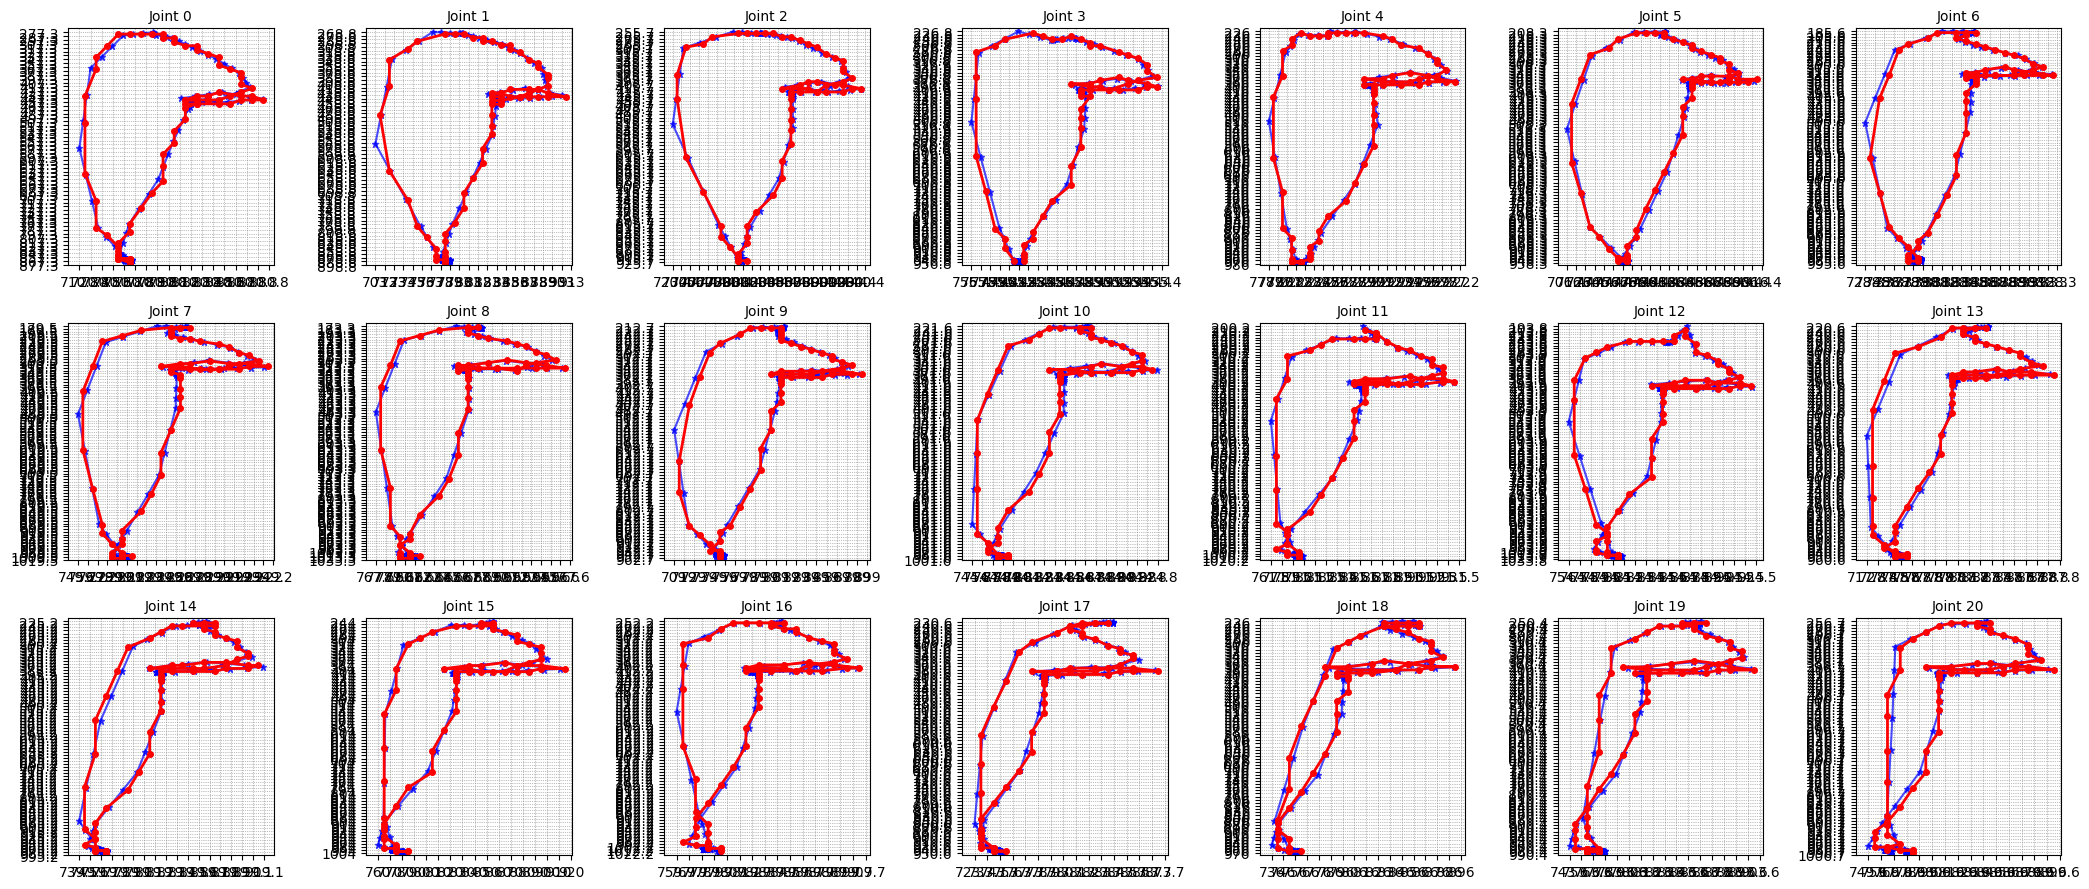

/tmp/ipykernel_1358147/226767238.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', num_joints)


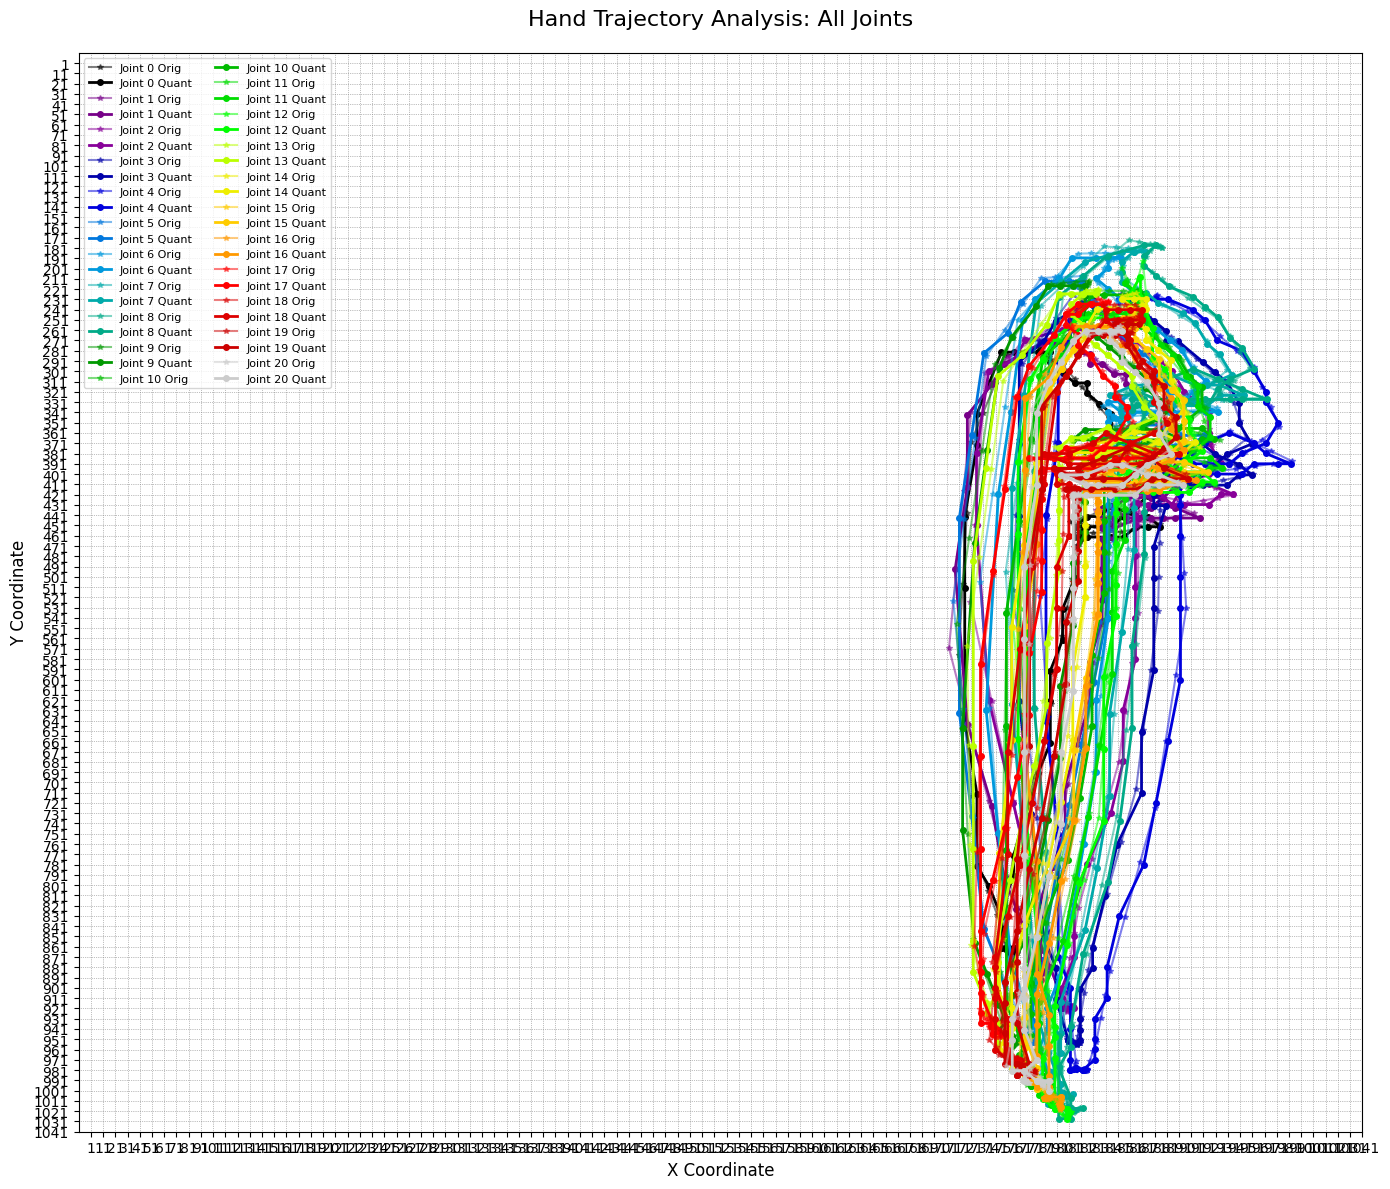

In [18]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# --- Load Data ---
with open("/nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01/NIA_SL_WORD0001_REAL01_F.pkl", "rb") as file:
    data = pickle.load(file)

# We assume 'hand_right' has shape (num_frames, 21, features)
hand_right = data['hand_right']

# --- Grid parameters ---
grid_size = 10  # size of each grid cell

def quantize_points(joint_points, grid_size):
    """
    Given an array of (x, y) points (shape: (num_frames, 2)), compute grid lines
    based on the point bounds and return the quantized point centers along with
    the grid lines and bounds.
    """
    x_min, x_max = joint_points[:, 0].min(), joint_points[:, 0].max()
    y_min, y_max = joint_points[:, 1].min(), joint_points[:, 1].max()
    
    # Generate grid lines with some padding
    dis = grid_size  # same as grid_size for consistency
    x_grid_lines = np.arange(x_min - grid_size + dis, x_max + grid_size + dis, grid_size)
    y_grid_lines = np.arange(y_min - grid_size + dis, y_max + grid_size + dis, grid_size)
    
    quantized_x, quantized_y = [], []
    for x, y in joint_points:
        x_cell = np.searchsorted(x_grid_lines, x) - 1
        y_cell = np.searchsorted(y_grid_lines, y) - 1
        
        if 0 <= x_cell < len(x_grid_lines) and 0 <= y_cell < len(y_grid_lines):
            x_center = x_grid_lines[x_cell] + grid_size / 2
            y_center = y_grid_lines[y_cell] + grid_size / 2
            # Append only if this grid cell center differs from the previous one
            if not quantized_x or (x_center != quantized_x[-1] or y_center != quantized_y[-1]):
                quantized_x.append(x_center)
                quantized_y.append(y_center)
                
    return quantized_x, quantized_y, x_grid_lines, y_grid_lines, x_min, x_max, y_min, y_max

num_joints = 21

###############################################################################
# Figure 1: 21 Subplots (One per Joint) in a Single Image
###############################################################################
# We'll arrange the subplots in a grid. Adjust the rows and columns as needed.
rows, cols = 3, 7  # 3 rows x 7 columns gives us 21 subplots
fig_subplots, axes = plt.subplots(rows, cols, figsize=(21, 9))
axes = axes.flatten()  # Convert the 2D array to 1D for easy iteration

for joint_index in range(num_joints):
    ax = axes[joint_index]
    joint_points = hand_right[:, joint_index, :2]  # shape: (num_frames, 2)
    qx, qy, x_grid_lines, y_grid_lines, x_min, x_max, y_min, y_max = quantize_points(joint_points, grid_size)
    
    # Plot the original trajectory
    ax.plot(joint_points[:, 0], joint_points[:, 1], 'b-*', label='Original', 
            alpha=0.7, markersize=5)
    # Plot the quantized trajectory
    ax.plot(qx, qy, 'r-o', linewidth=2, markersize=4, label='Quantized')
    
    # Set the grid and axis limits for this subplot
    ax.set_xticks(x_grid_lines)
    ax.set_yticks(y_grid_lines)
    ax.grid(linestyle=':', linewidth=0.5, color='gray')
    ax.set_xlim(x_min - grid_size, x_max + grid_size)
    ax.set_ylim(y_min - grid_size, y_max + grid_size)
    ax.invert_yaxis()  # Invert y-axis if necessary for your coordinate system
    
    ax.set_title(f'Joint {joint_index}', fontsize=10)
    # Optionally enable the legend (it might be crowded for small subplots)
    # ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

###############################################################################
# Figure 2: Combined Plot of All 21 Joints on One Axes with a Global Grid
###############################################################################
# Compute global bounds from all joints for consistent scaling
all_points = hand_right.reshape(-1, 2)
global_x_min, global_x_max = all_points[:, 0].min(), all_points[:, 0].max()
global_y_min, global_y_max = all_points[:, 1].min(), all_points[:, 1].max()

# Compute global grid lines based on the overall bounds
dis = grid_size
global_x_grid_lines = np.arange(global_x_min - grid_size + dis, 
                                global_x_max + grid_size + dis, grid_size)
global_y_grid_lines = np.arange(global_y_min - grid_size + dis, 
                                global_y_max + grid_size + dis, grid_size)

fig_all, ax_all = plt.subplots(figsize=(14, 12))
colors = plt.cm.get_cmap('nipy_spectral', num_joints)

for joint_index in range(num_joints):
    joint_points = hand_right[:, joint_index, :2]
    qx, qy, _, _, _, _, _, _ = quantize_points(joint_points, grid_size)
    
    color = colors(joint_index)
    # Plot original trajectory for the joint
    ax_all.plot(joint_points[:, 0], joint_points[:, 1], '-*', color=color,
                alpha=0.5, markersize=4, label=f'Joint {joint_index} Orig')
    # Plot quantized trajectory for the joint
    ax_all.plot(qx, qy, '-o', color=color, linewidth=2, markersize=4,
                label=f'Joint {joint_index} Quant')

# Set the global axis limits
ax_all.set_xlim(global_x_min - grid_size, global_x_max + grid_size)
ax_all.set_ylim(global_y_min - grid_size, global_y_max + grid_size)
ax_all.invert_yaxis()
ax_all.set_xlabel('X Coordinate', fontsize=12)
ax_all.set_ylabel('Y Coordinate', fontsize=12)
ax_all.set_title('Hand Trajectory Analysis: All Joints', fontsize=16, pad=20)

# Apply the global grid
ax_all.set_xticks(global_x_grid_lines)
ax_all.set_yticks(global_y_grid_lines)
ax_all.grid(linestyle=':', linewidth=0.5, color='gray')

# Because the legend may become crowded, you can choose to show it or not.
# The following line shows the legend. If it overlaps the plot, you can comment it out.
ax_all.legend(loc='upper left', fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


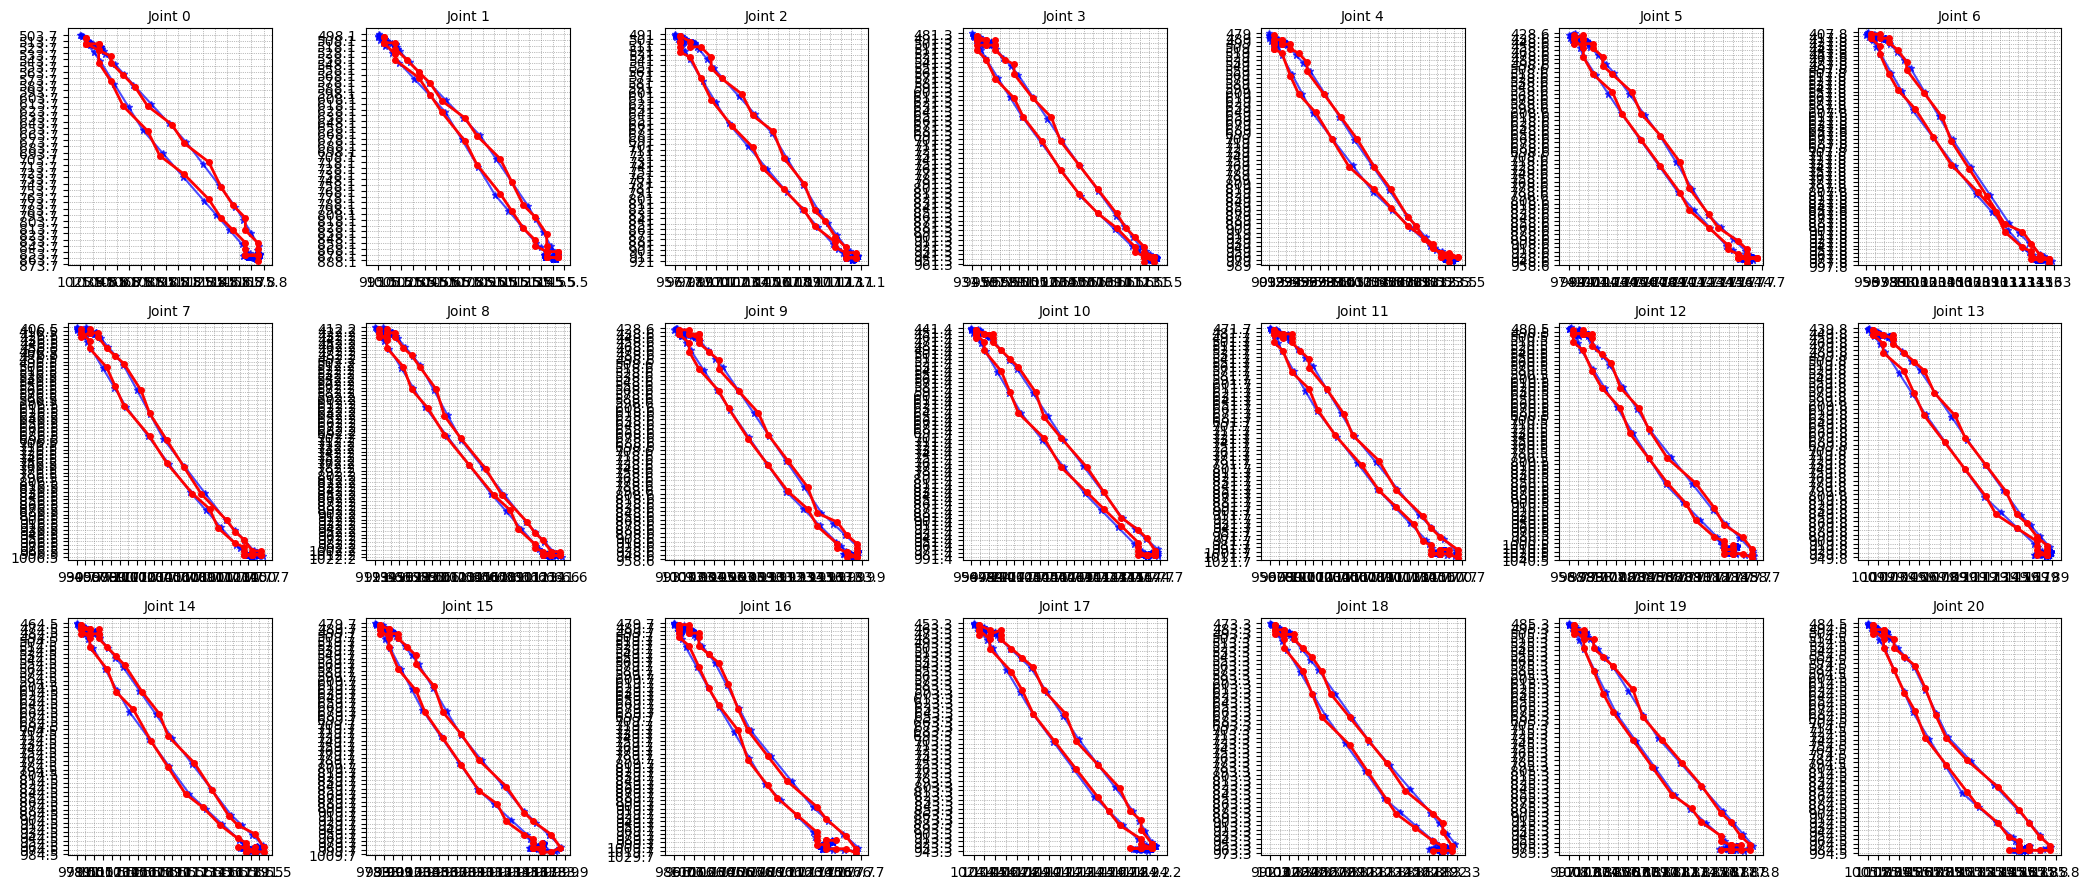

/tmp/ipykernel_1358147/3299793195.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', num_joints)


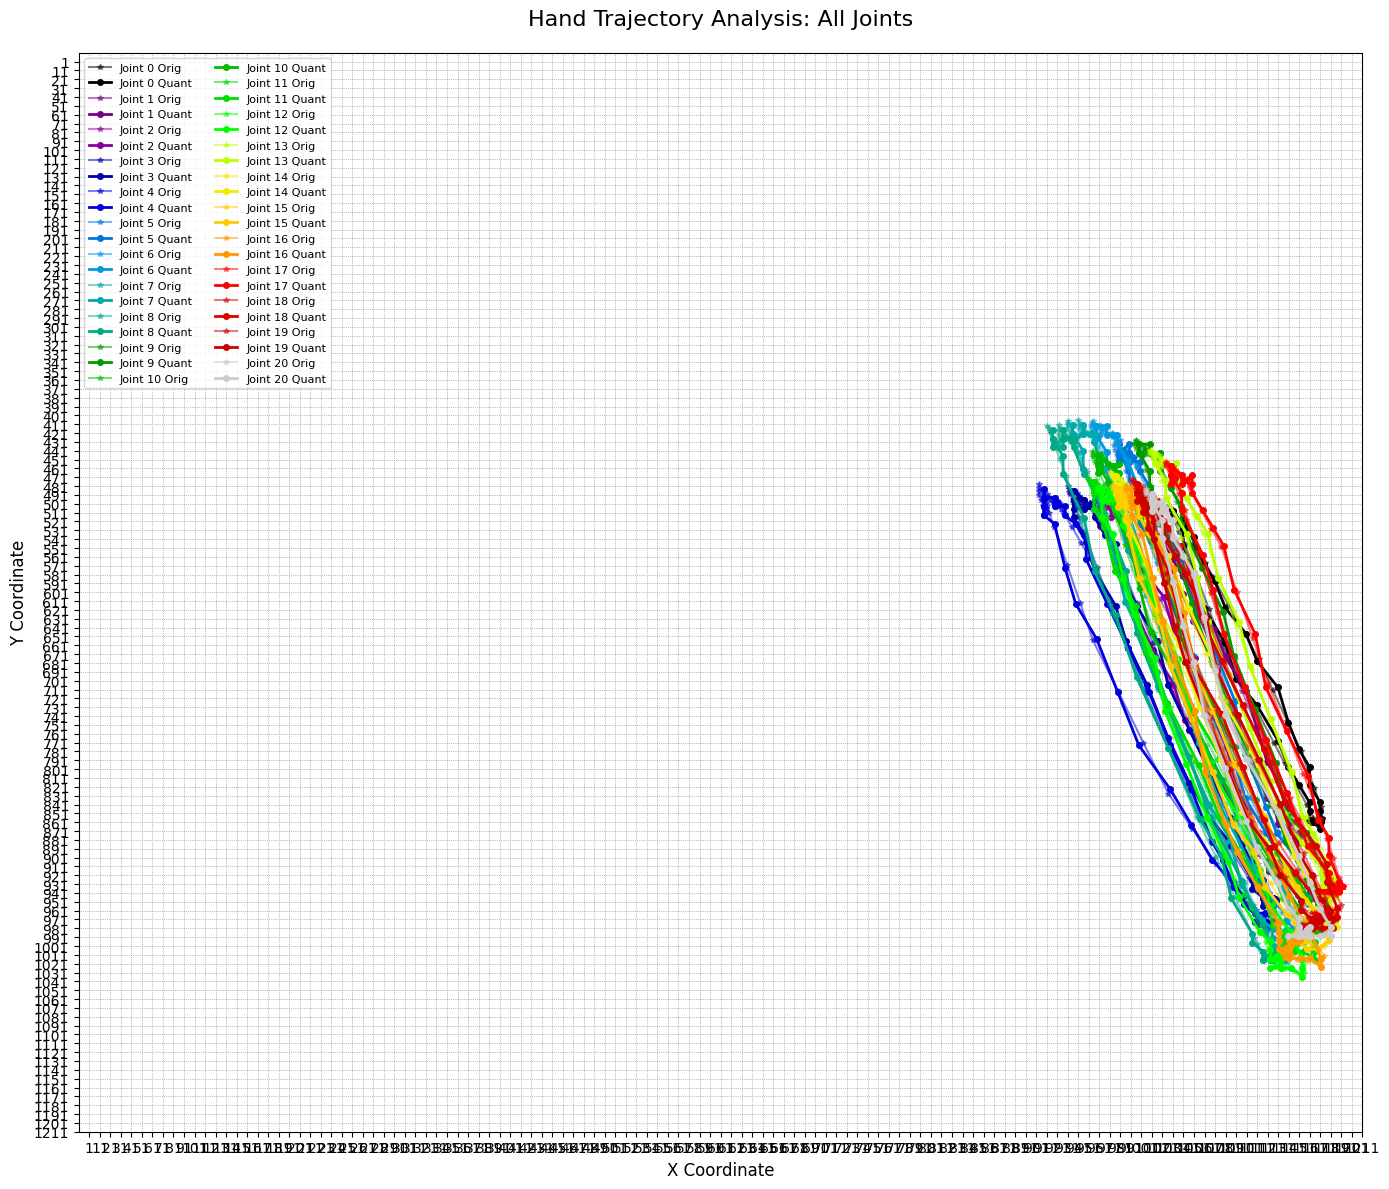

In [19]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# --- Load Data ---
with open("/nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01/NIA_SL_WORD0001_REAL01_F.pkl", "rb") as file:
    data = pickle.load(file)

# We assume 'hand_right' has shape (num_frames, 21, features)
hand_right = data['hand_left']

# --- Grid parameters ---
grid_size = 10  # size of each grid cell

def quantize_points(joint_points, grid_size):
    """
    Given an array of (x, y) points (shape: (num_frames, 2)), compute grid lines
    based on the point bounds and return the quantized point centers along with
    the grid lines and bounds.
    """
    x_min, x_max = joint_points[:, 0].min(), joint_points[:, 0].max()
    y_min, y_max = joint_points[:, 1].min(), joint_points[:, 1].max()
    
    # Generate grid lines with some padding
    dis = grid_size  # same as grid_size for consistency
    x_grid_lines = np.arange(x_min - grid_size + dis, x_max + grid_size + dis, grid_size)
    y_grid_lines = np.arange(y_min - grid_size + dis, y_max + grid_size + dis, grid_size)
    
    quantized_x, quantized_y = [], []
    for x, y in joint_points:
        x_cell = np.searchsorted(x_grid_lines, x) - 1
        y_cell = np.searchsorted(y_grid_lines, y) - 1
        
        if 0 <= x_cell < len(x_grid_lines) and 0 <= y_cell < len(y_grid_lines):
            x_center = x_grid_lines[x_cell] + grid_size / 2
            y_center = y_grid_lines[y_cell] + grid_size / 2
            # Append only if this grid cell center differs from the previous one
            if not quantized_x or (x_center != quantized_x[-1] or y_center != quantized_y[-1]):
                quantized_x.append(x_center)
                quantized_y.append(y_center)
                
    return quantized_x, quantized_y, x_grid_lines, y_grid_lines, x_min, x_max, y_min, y_max

num_joints = 21

###############################################################################
# Figure 1: 21 Subplots (One per Joint) in a Single Image
###############################################################################
# We'll arrange the subplots in a grid. Adjust the rows and columns as needed.
rows, cols = 3, 7  # 3 rows x 7 columns gives us 21 subplots
fig_subplots, axes = plt.subplots(rows, cols, figsize=(21, 9))
axes = axes.flatten()  # Convert the 2D array to 1D for easy iteration

for joint_index in range(num_joints):
    ax = axes[joint_index]
    joint_points = hand_right[:, joint_index, :2]  # shape: (num_frames, 2)
    qx, qy, x_grid_lines, y_grid_lines, x_min, x_max, y_min, y_max = quantize_points(joint_points, grid_size)
    
    # Plot the original trajectory
    ax.plot(joint_points[:, 0], joint_points[:, 1], 'b-*', label='Original', 
            alpha=0.7, markersize=5)
    # Plot the quantized trajectory
    ax.plot(qx, qy, 'r-o', linewidth=2, markersize=4, label='Quantized')
    
    # Set the grid and axis limits for this subplot
    ax.set_xticks(x_grid_lines)
    ax.set_yticks(y_grid_lines)
    ax.grid(linestyle=':', linewidth=0.5, color='gray')
    ax.set_xlim(x_min - grid_size, x_max + grid_size)
    ax.set_ylim(y_min - grid_size, y_max + grid_size)
    ax.invert_yaxis()  # Invert y-axis if necessary for your coordinate system
    
    ax.set_title(f'Joint {joint_index}', fontsize=10)
    # Optionally enable the legend (it might be crowded for small subplots)
    # ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

###############################################################################
# Figure 2: Combined Plot of All 21 Joints on One Axes with a Global Grid
###############################################################################
# Compute global bounds from all joints for consistent scaling
all_points = hand_right.reshape(-1, 2)
global_x_min, global_x_max = all_points[:, 0].min(), all_points[:, 0].max()
global_y_min, global_y_max = all_points[:, 1].min(), all_points[:, 1].max()

# Compute global grid lines based on the overall bounds
dis = grid_size
global_x_grid_lines = np.arange(global_x_min - grid_size + dis, 
                                global_x_max + grid_size + dis, grid_size)
global_y_grid_lines = np.arange(global_y_min - grid_size + dis, 
                                global_y_max + grid_size + dis, grid_size)

fig_all, ax_all = plt.subplots(figsize=(14, 12))
colors = plt.cm.get_cmap('nipy_spectral', num_joints)

for joint_index in range(num_joints):
    joint_points = hand_right[:, joint_index, :2]
    qx, qy, _, _, _, _, _, _ = quantize_points(joint_points, grid_size)
    
    color = colors(joint_index)
    # Plot original trajectory for the joint
    ax_all.plot(joint_points[:, 0], joint_points[:, 1], '-*', color=color,
                alpha=0.5, markersize=4, label=f'Joint {joint_index} Orig')
    # Plot quantized trajectory for the joint
    ax_all.plot(qx, qy, '-o', color=color, linewidth=2, markersize=4,
                label=f'Joint {joint_index} Quant')

# Set the global axis limits
ax_all.set_xlim(global_x_min - grid_size, global_x_max + grid_size)
ax_all.set_ylim(global_y_min - grid_size, global_y_max + grid_size)
ax_all.invert_yaxis()
ax_all.set_xlabel('X Coordinate', fontsize=12)
ax_all.set_ylabel('Y Coordinate', fontsize=12)
ax_all.set_title('Hand Trajectory Analysis: All Joints', fontsize=16, pad=20)

# Apply the global grid
ax_all.set_xticks(global_x_grid_lines)
ax_all.set_yticks(global_y_grid_lines)
ax_all.grid(linestyle=':', linewidth=0.5, color='gray')

# Because the legend may become crowded, you can choose to show it or not.
# The following line shows the legend. If it overlaps the plot, you can comment it out.
ax_all.legend(loc='upper left', fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


/tmp/ipykernel_1358147/2798640012.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', 21)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


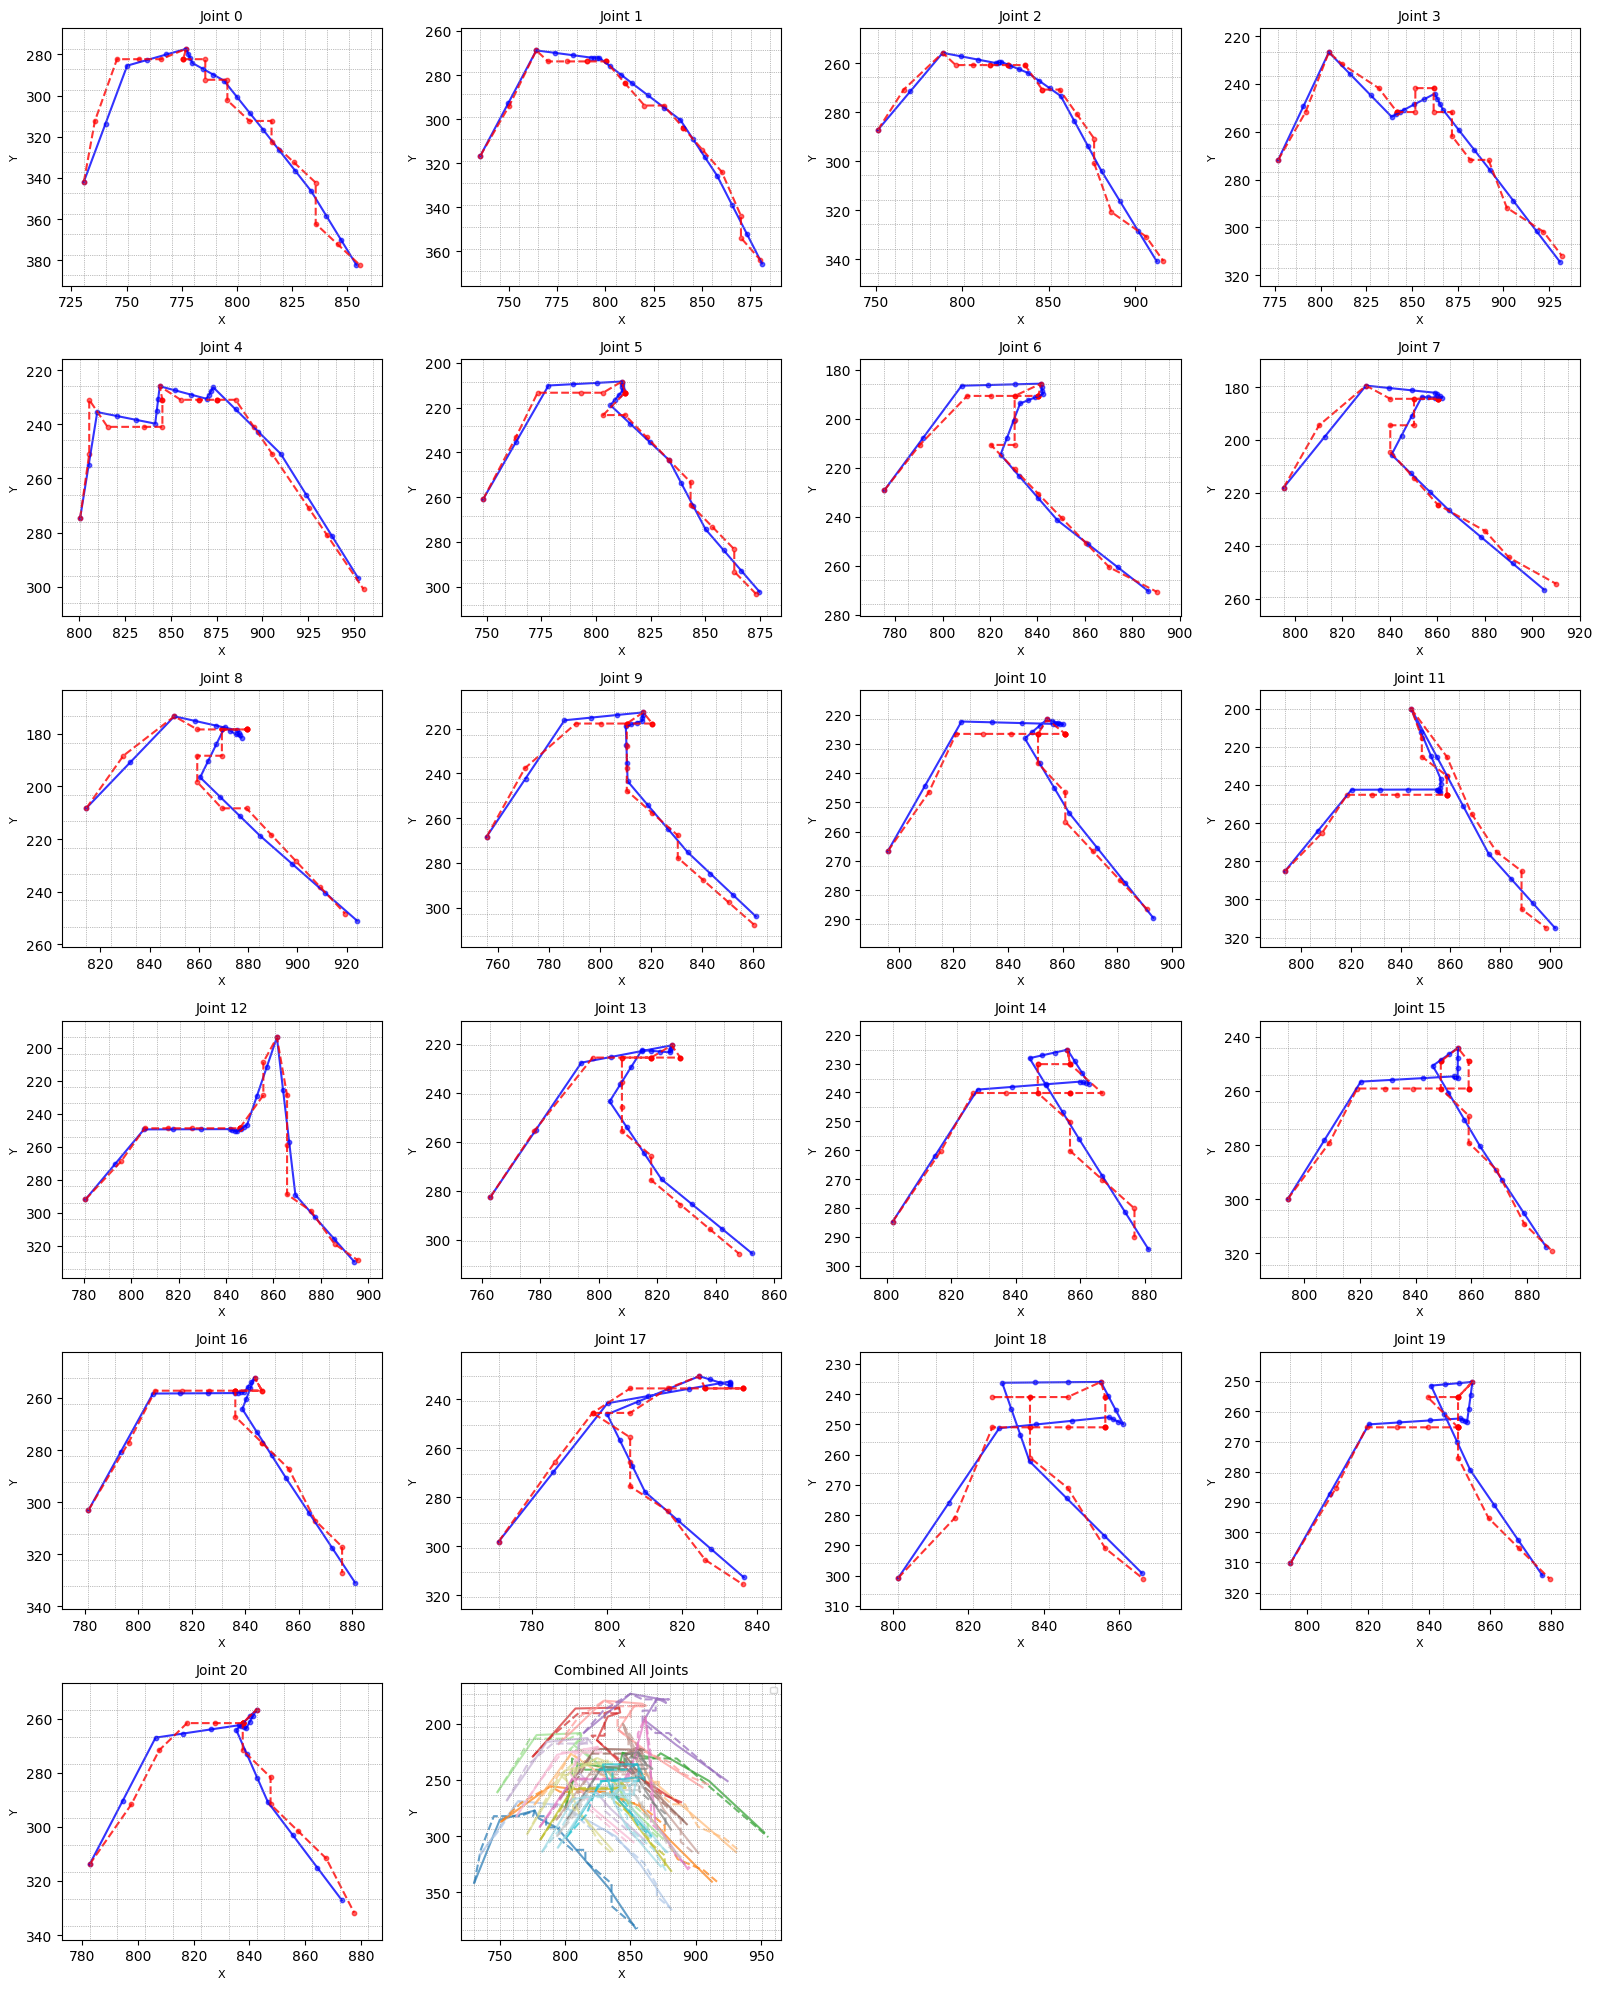

In [ ]:
# import os
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt

# def compute_grid_lines(points, grid_size=10):
#     """
#     Compute grid lines based on the points in one dimension.
    
#     Parameters:
#         points (np.ndarray): 1D array of coordinate values.
#         grid_size (float): Spacing for grid lines.
    
#     Returns:
#         np.ndarray: Array of grid line positions.
#     """
#     # In the quantization function we used:
#     #   x_grid_lines = np.arange(x_min, x_max + 2*grid_size, grid_size)
#     # (since dis = grid_size)
#     min_val = points.min()
#     max_val = points.max()
#     grid_lines = np.arange(min_val, max_val + 2*grid_size, grid_size)
#     return grid_lines

# def plot_joint_subplot(ax, original_points, quantized_points, joint_index, grid_size=10):
#     """
#     Plot a single subplot overlaying the original and quantized trajectory for one joint.
    
#     Parameters:
#         ax (matplotlib.axes.Axes): The subplot axis to draw on.
#         original_points (np.ndarray): Array of shape (n_frames, 2) with original (x,y) coordinates.
#         quantized_points (np.ndarray): Array of shape (n_frames, 2) with quantized (x,y) coordinates.
#         joint_index (int): The joint index.
#         grid_size (float): Spacing for the grid lines.
#     """
#     # Plot original trajectory (solid blue) and quantized trajectory (red dashed)
#     ax.plot(original_points[:, 0], original_points[:, 1], 'b-', label='Orig', alpha=0.8)
#     ax.plot(quantized_points[:, 0], quantized_points[:, 1], 'r--', label='Quant', alpha=0.8)
#     ax.scatter(original_points[:, 0], original_points[:, 1], color='blue', s=10, alpha=0.6)
#     ax.scatter(quantized_points[:, 0], quantized_points[:, 1], color='red', s=10, alpha=0.6)
    
#     # Compute grid lines based on both original and quantized data for consistency.
#     x_all = np.concatenate([original_points[:,0], quantized_points[:,0]])
#     y_all = np.concatenate([original_points[:,1], quantized_points[:,1]])
#     x_grid = compute_grid_lines(x_all, grid_size)
#     y_grid = compute_grid_lines(y_all, grid_size)
    
#     # Draw grid lines manually.
#     for x in x_grid:
#         ax.axvline(x, color='gray', linestyle=':', linewidth=0.5)
#     for y in y_grid:
#         ax.axhline(y, color='gray', linestyle=':', linewidth=0.5)
    
#     # Set plot limits slightly beyond the data range.
#     ax.set_xlim(x_all.min() - grid_size, x_all.max() + grid_size)
#     ax.set_ylim(y_all.min() - grid_size, y_all.max() + grid_size)
    
#     ax.set_title(f"Joint {joint_index}", fontsize=10)
#     ax.set_xlabel("X", fontsize=8)
#     ax.set_ylabel("Y", fontsize=8)
#     ax.invert_yaxis()  # If you use image coordinates

# def plot_combined_subplot(ax, orig_points_dict, quant_points_dict, grid_size=10):
#     """
#     Plot a combined subplot overlaying the trajectories for all 21 joints.
    
#     Parameters:
#         ax (matplotlib.axes.Axes): The subplot axis.
#         orig_points_dict (dict): Dictionary mapping joint index (0-20) to original (n_frames, 2) data.
#         quant_points_dict (dict): Dictionary mapping joint index (0-20) to quantized (n_frames, 2) data.
#         grid_size (float): Spacing for grid lines.
#     """
#     cmap = plt.cm.get_cmap('tab20', 21)
    
#     all_x, all_y = [], []
#     for j in range(21):
#         orig = orig_points_dict[j]
#         quant = quant_points_dict[j]
#         all_x.extend(orig[:,0])
#         all_x.extend(quant[:,0])
#         all_y.extend(orig[:,1])
#         all_y.extend(quant[:,1])
#         ax.plot(orig[:, 0], orig[:, 1], color=cmap(j), linestyle='-', alpha=0.7)
#         ax.plot(quant[:, 0], quant[:, 1], color=cmap(j), linestyle='--', alpha=0.7)
    
#     all_x = np.array(all_x)
#     all_y = np.array(all_y)
#     x_grid = compute_grid_lines(all_x, grid_size)
#     y_grid = compute_grid_lines(all_y, grid_size)
#     for x in x_grid:
#         ax.axvline(x, color='gray', linestyle=':', linewidth=0.5)
#     for y in y_grid:
#         ax.axhline(y, color='gray', linestyle=':', linewidth=0.5)
    
#     ax.set_xlim(all_x.min() - grid_size, all_x.max() + grid_size)
#     ax.set_ylim(all_y.min() - grid_size, all_y.max() + grid_size)
#     ax.invert_yaxis()
#     ax.set_title("Combined All Joints", fontsize=10)
#     ax.set_xlabel("X", fontsize=8)
#     ax.set_ylabel("Y", fontsize=8)
#     ax.legend(fontsize=6, ncol=2, loc='upper right')

# # === Main Script ===

# # Directories (adjust these paths as needed)
# threshold_dir = r"/nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01_threshold/"
# quantized_dir  = r"/nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01_quantized/"

# # Specify the file name (ensure the same file exists in both directories)
# filename = "NIA_SL_WORD0001_REAL01_F.pkl"  # Replace with your actual file name

# # Load the threshold (raw/original) data
# with open(os.path.join(threshold_dir, filename), 'rb') as f:
#     thresh_data = pickle.load(f)

# # Load the quantized data
# with open(os.path.join(quantized_dir, filename), 'rb') as f:
#     quant_data = pickle.load(f)

# # Assumptions:
# # - The threshold file contains original right-hand keypoints under "hand_right"
# #   with shape (n_frames, 21, 3); we use the first two columns (x,y).
# # - The quantized file contains quantized right-hand data under "hand_right_quantized",
# #   which is a dictionary mapping joint indices (0 to 20) to arrays of shape (n_frames, 2).

# orig_hand_right = thresh_data['hand_right']        # shape: (n_frames, 21, 3)
# quant_hand_right = quant_data['hand_right_quantized'] # dict: {0: (n_frames,2), ..., 20: (n_frames,2)}

# # Create a dictionary mapping joint index to (n_frames,2) arrays for original data.
# orig_joints_dict = {j: orig_hand_right[:, j, :2] for j in range(21)}

# # Create one figure with 22 subplots (e.g., 6 rows x 4 columns = 24 subplots; we'll leave 2 blank).
# n_rows, n_cols = 6, 4
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 20))
# axs = axs.flatten()  # Flatten to 1D array for easy indexing

# # Plot individual joint comparisons (subplots 0-20).
# for j in range(21):
#     plot_joint_subplot(axs[j], orig_joints_dict[j], quant_hand_right[j], joint_index=j, grid_size=10)

# # Plot a combined graph (subplot 21) showing all joints.
# plot_combined_subplot(axs[21], orig_joints_dict, quant_hand_right, grid_size=10)

# # Turn off any unused subplots.
# for k in range(22, len(axs)):
#     axs[k].axis('off')

# plt.tight_layout()
# plt.show()


/tmp/ipykernel_1358147/1272655367.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', 21)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


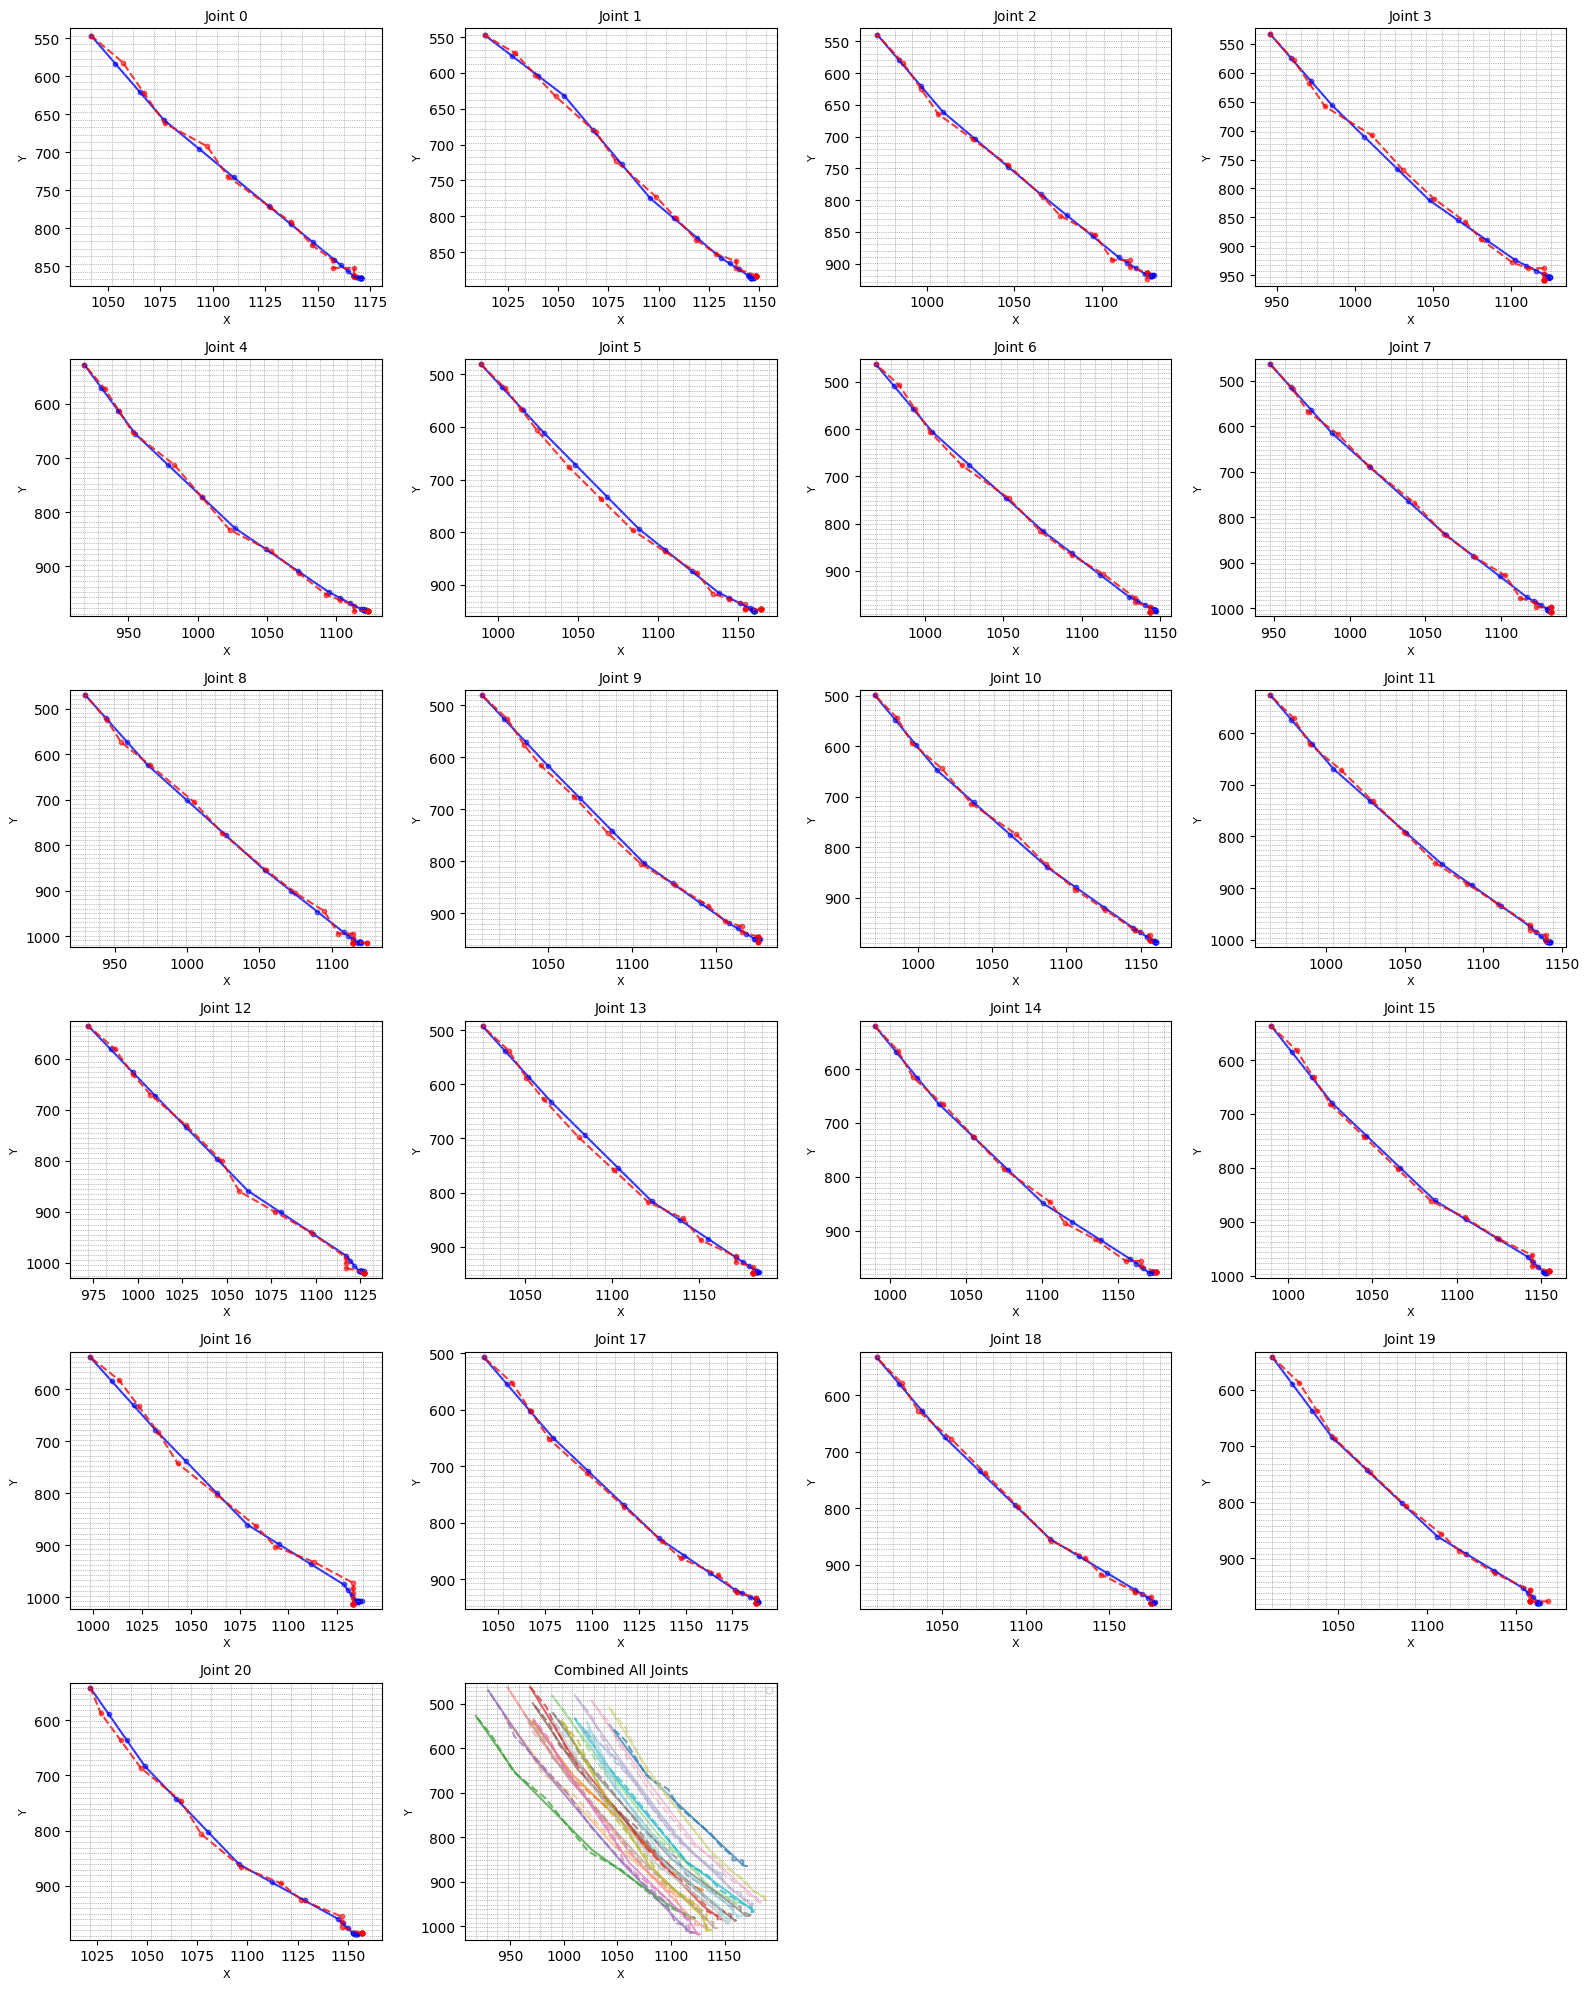

In [17]:
# import os
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt

# def compute_grid_lines(points, grid_size=10):
#     """
#     Compute grid lines based on the points in one dimension.
    
#     Parameters:
#         points (np.ndarray): 1D array of coordinate values.
#         grid_size (float): Spacing for grid lines.
    
#     Returns:
#         np.ndarray: Array of grid line positions.
#     """
#     min_val = points.min()
#     max_val = points.max()
#     grid_lines = np.arange(min_val, max_val + 2*grid_size, grid_size)
#     return grid_lines

# def plot_joint_subplot(ax, original_points, quantized_points, joint_index, grid_size=10, hand_label="Left"):
#     """
#     Plot a single subplot overlaying the original and quantized trajectory for one joint.
    
#     Parameters:
#         ax (matplotlib.axes.Axes): The subplot axis to draw on.
#         original_points (np.ndarray): Array of shape (n_frames, 2) with original (x,y) coordinates.
#         quantized_points (np.ndarray): Array of shape (n_frames, 2) with quantized (x,y) coordinates.
#         joint_index (int): The joint index.
#         grid_size (float): Spacing for the grid lines.
#         hand_label (str): Label for the hand.
#     """
#     # Plot original trajectory (solid blue) and quantized trajectory (red dashed)
#     ax.plot(original_points[:, 0], original_points[:, 1], 'b-', label='Orig', alpha=0.8)
#     ax.plot(quantized_points[:, 0], quantized_points[:, 1], 'r--', label='Quant', alpha=0.8)
#     ax.scatter(original_points[:, 0], original_points[:, 1], color='blue', s=10, alpha=0.6)
#     ax.scatter(quantized_points[:, 0], quantized_points[:, 1], color='red', s=10, alpha=0.6)
    
#     # Combine data to compute grid lines consistently.
#     x_all = np.concatenate([original_points[:, 0], quantized_points[:, 0]])
#     y_all = np.concatenate([original_points[:, 1], quantized_points[:, 1]])
#     x_grid = compute_grid_lines(x_all, grid_size)
#     y_grid = compute_grid_lines(y_all, grid_size)
    
#     # Draw grid lines
#     for x in x_grid:
#         ax.axvline(x, color='gray', linestyle=':', linewidth=0.5)
#     for y in y_grid:
#         ax.axhline(y, color='gray', linestyle=':', linewidth=0.5)
    
#     # Set plot limits slightly beyond the data range.
#     ax.set_xlim(x_all.min() - grid_size, x_all.max() + grid_size)
#     ax.set_ylim(y_all.min() - grid_size, y_all.max() + grid_size)
    
#     ax.set_title(f"Joint {joint_index}", fontsize=10)
#     ax.set_xlabel("X", fontsize=8)
#     ax.set_ylabel("Y", fontsize=8)
#     ax.invert_yaxis()  # Common if using image coordinates

# def plot_combined_subplot(ax, orig_points_dict, quant_points_dict, grid_size=10, hand_label="Left"):
#     """
#     Plot a combined subplot overlaying the trajectories for all 21 joints of the left hand.
    
#     Parameters:
#         ax (matplotlib.axes.Axes): The subplot axis.
#         orig_points_dict (dict): Dictionary mapping joint index (0-20) to original (n_frames, 2) data.
#         quant_points_dict (dict): Dictionary mapping joint index (0-20) to quantized (n_frames, 2) data.
#         grid_size (float): Spacing for grid lines.
#         hand_label (str): Label for the hand.
#     """
#     cmap = plt.cm.get_cmap('tab20', 21)
#     all_x, all_y = [], []
    
#     for j in range(21):
#         orig = orig_points_dict[j]
#         quant = quant_points_dict[j]
#         all_x.extend(orig[:, 0])
#         all_x.extend(quant[:, 0])
#         all_y.extend(orig[:, 1])
#         all_y.extend(quant[:, 1])
#         ax.plot(orig[:, 0], orig[:, 1], color=cmap(j), linestyle='-', alpha=0.7)
#         ax.plot(quant[:, 0], quant[:, 1], color=cmap(j), linestyle='--', alpha=0.7)
    
#     all_x = np.array(all_x)
#     all_y = np.array(all_y)
#     x_grid = compute_grid_lines(all_x, grid_size)
#     y_grid = compute_grid_lines(all_y, grid_size)
#     for x in x_grid:
#         ax.axvline(x, color='gray', linestyle=':', linewidth=0.5)
#     for y in y_grid:
#         ax.axhline(y, color='gray', linestyle=':', linewidth=0.5)
    
#     ax.set_xlim(all_x.min() - grid_size, all_x.max() + grid_size)
#     ax.set_ylim(all_y.min() - grid_size, all_y.max() + grid_size)
#     ax.invert_yaxis()
#     ax.set_title("Combined All Joints", fontsize=10)
#     ax.set_xlabel("X", fontsize=8)
#     ax.set_ylabel("Y", fontsize=8)
#     ax.legend(fontsize=6, ncol=2, loc='upper right')

# # === Main Script ===

# # Set the directories for threshold (raw) and quantized files for left hand.
# threshold_dir = r"/nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01_threshold/"
# quantized_dir  = r"/nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01_quantized/"

# # Specify the file name (ensure the same file exists in both directories)
# filename = "NIA_SL_WORD0001_REAL01_F.pkl"  # Replace with your actual file name

# # Load the threshold (raw) data
# with open(os.path.join(threshold_dir, filename), 'rb') as f:
#     thresh_data = pickle.load(f)

# # Load the quantized data
# with open(os.path.join(quantized_dir, filename), 'rb') as f:
#     quant_data = pickle.load(f)

# # For left hand:
# # - The threshold file should have left-hand keypoints under "hand_left" with shape (n_frames, 21, 3)
# # - The quantized file should have left-hand quantized data under "hand_left_quantized" as a dictionary {0: (n_frames,2), ... 20: (n_frames,2)}
# orig_hand_left = thresh_data['hand_left']        # shape: (n_frames, 21, 3)
# quant_hand_left = quant_data['hand_left_quantized'] # dictionary mapping joint index to (n_frames, 2)

# # Create dictionary mapping joint index to (n_frames,2) arrays for left hand original data.
# orig_joints_left = {j: orig_hand_left[:, j, :2] for j in range(21)}

# # Create one figure with 22 subplots (for 21 joints plus one combined subplot).
# n_rows, n_cols = 6, 4  # Total subplots = 24; we will use 22 and leave 2 blank.
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 20))
# axs = axs.flatten()  # Flatten to 1D array for indexing

# # Plot individual joint comparisons for joints 0 to 20 (subplots 0-20).
# for j in range(21):
#     plot_joint_subplot(axs[j], orig_joints_left[j], quant_hand_left[j], joint_index=j, grid_size=10, hand_label="Left")

# # Plot the combined graph for all joints in subplot 21.
# plot_combined_subplot(axs[21], orig_joints_left, quant_hand_left, grid_size=10, hand_label="Left")

# # Turn off any unused subplots.
# for k in range(22, len(axs)):
#     axs[k].axis('off')

# plt.tight_layout()
# plt.show()
